In [1]:
import pandas as pd
import requests
from urllib.parse import urlencode
import json, datetime
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
%matplotlib inline

mpl.style.use('seaborn')
api_key = "94bd224fdd23e740f91f7fc88375518f"

city = "Warsaw"
unit = "metric"

In [2]:
params = dict(
    q=city,
    appid=api_key
)

url = 'http://api.openweathermap.org/data/2.5/forecast?q={}&units={}&APPID={}'.format(city, unit, api_key)
r = requests.get(url)
weather = json.loads(r.text)
df = pd.DataFrame.from_dict(weather['list'])

In [3]:
from datetime import datetime

def _dict_to_val(_dict):
    try:
        return list(_dict.values())[0]
    except:
        return 0

df["clouds"] = df.apply(lambda x: x.clouds["all"], axis=1)
df["rain"] = df.apply(lambda x: _dict_to_val(x.rain), axis=1)
df["snow"] = df.apply(lambda x: _dict_to_val(x.snow), axis=1)
df["sys"] = df.apply(lambda x: list(x.sys["pod"]), axis=1)
df["dt_txt1"] = df.apply(lambda x: datetime.strptime(x.dt_txt, '%Y-%m-%d %H:%M:%S'), axis=1)
df["date"] = df.apply(lambda x: x.dt_txt1.date(), axis=1)
df["time"] = df.apply(lambda x: x.dt_txt1.time(), axis=1)

df  = df.merge(df.wind.apply(lambda s: pd.Series({'wind_speed':s["speed"], 'wind_deg':s["deg"]})), 
    left_index=True, right_index=True)
df = df.merge(df.main.apply(lambda s: pd.Series({'temp':s["temp"], 'temp_min':s["temp_min"], 'temp_max':s["temp_max"], 'pressure': s['pressure'], "sea_level": s["sea_level"], "grnd_level": s["grnd_level"], "humidity": s["humidity"], "temp_kf": s["temp_kf"]})), 
    left_index=True, right_index=True)

df = df.drop(columns=["main", "wind", "weather", "dt_txt"])

def temp_odcz(temp, wind_speed):
    return 13.12 + 0.6215 * temp - 11.37 * wind_speed**0.16 + 0.3965 * temp * wind_speed**0.16

def temp_pkt_rosy(temp, humidity):
    return (humidity/100)**(1/float(8)) * abs(112 + (0.9 * temp)) + (0.1 * temp) - 112

pd.options.mode.chained_assignment = None  # default='warn'

df["wind_speed_kmh"] = df.apply(lambda x: x.wind_speed * 3.6, axis=1)
df["temp_odcz"] = df.apply(lambda row: temp_odcz(row.temp, row.wind_speed), axis=1)
df["temp_odcz_min"] = df.apply(lambda row: temp_odcz(row.temp_min, row.wind_speed), axis=1)
df["temp_odcz_max"] = df.apply(lambda row: temp_odcz(row.temp_max, row.wind_speed), axis=1)
df["temp_pkt_rosy"] = df.apply(lambda row: temp_pkt_rosy(row.temp, row.humidity), axis=1)


In [4]:
pd.set_option('display.max_columns',500)

def getDateFrame(date):
    df2 = df.loc[df["date"] == datetime.strptime(date, "%Y-%m-%d").date()]
    return df2

In [5]:
chosenDf = getDateFrame("2019-01-08")
chosenDf

,clouds,dt,rain,snow,sys,dt_txt1,date,time,wind_speed,wind_deg,temp,temp_min,temp_max,pressure,sea_level,grnd_level,humidity,temp_kf,wind_speed_kmh,temp_odcz,temp_odcz_min,temp_odcz_max,temp_pkt_rosy
17,24,1546905600,0,0.0025,[n],2019-01-08 00:00:00,2019-01-08,00:00:00,4.66,202.502,-8.88,-8.88,-8.88,1019.61,1032.74,1019.61,84.0,0.0,16.776,-11.447529,-11.447529,-11.447529,-11.122246
18,48,1546916400,0,0.0125,[n],2019-01-08 03:00:00,2019-01-08,03:00:00,5.21,195.004,-7.99,-7.99,-7.99,1015.94,1028.98,1015.94,83.0,0.0,18.756,-10.777927,-10.777927,-10.777927,-10.402918
19,88,1546927200,0,0.1325,[n],2019-01-08 06:00:00,2019-01-08,06:00:00,5.47,185.502,-5.84,-5.84,-5.84,1011.65,1024.68,1011.65,86.0,0.0,19.692,-8.470975,-8.470975,-8.470975,-7.833578
20,64,1546938000,0,0.0425,[d],2019-01-08 09:00:00,2019-01-08,09:00:00,6.21,183.503,-4.87,-4.87,-4.87,1008.23,1021.16,1008.23,87.0,0.0,22.356,-7.721363,-7.721363,-7.721363,-6.727159
21,92,1546948800,0,0.1725,[d],2019-01-08 12:00:00,2019-01-08,12:00:00,6.71,186.001,-2.68,-2.68,-2.68,1004.78,1017.50,1004.78,88.0,0.0,24.156,-5.404870,-5.404870,-5.404870,-4.417209
22,92,1546959600,0,1.2450,[n],2019-01-08 15:00:00,2019-01-08,15:00:00,6.43,183.500,-1.98,-1.98,-1.98,1002.17,1014.91,1002.17,91.0,0.0,23.148,-4.481420,-4.481420,-4.481420,-3.271713
23,92,1546970400,0,0.9000,[n],2019-01-08 18:00:00,2019-01-08,18:00:00,6.26,177.004,-1.91,-1.91,-1.91,1000.26,1012.87,1000.26,87.0,0.0,22.536,-4.330660,-4.330660,-4.330660,-3.813132
24,92,1546981200,0,0.2250,[n],2019-01-08 21:00:00,2019-01-08,21:00:00,5.72,171.504,-2.07,-2.07,-2.07,999.02,1011.68,999.02,91.0,0.0,20.592,-4.280899,-4.280899,-4.280899,-3.360764


In [6]:
def plot_temperature(date_df):
    fig, ax = plt.subplots()
    x = date_df["dt_txt1"].dt.hour
    plt.xticks(x)
    minimum = min(date_df['temp_odcz'].min(), date_df['temp_pkt_rosy'].min())
    maximum = max(date_df['temp_odcz'].max(), date_df['temp_pkt_rosy'].max())
    plt.ylim(minimum - 2, 10)
    plt.plot(x, date_df['temp'], 'r', zorder =2) 
    plt.plot(x, date_df['temp_odcz'], 'b')  
    plt.plot(x, date_df['temp_pkt_rosy'], 'm*') 
    plt.grid(True)
    plt.axhspan(minimum - 2, 0, facecolor='#73bdfe', alpha = 0.3)
    plt.show()



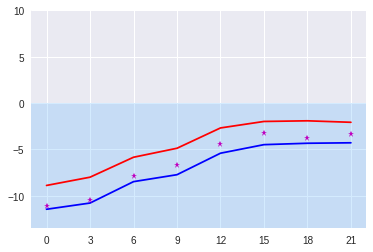

In [7]:
plot_temperature(chosenDf)

In [16]:
import math
def get_change(deg, radius):
    rad = math.radians(deg % 360);
    dx = radius * math.cos(rad);
    dy = -radius * math.sin(rad);
    return [dx, dy];

def plot_wind_direction(date_df):
    fig, ax = plt.subplots()
    plt.xlim(-3,24)
    plt.ylim(-15,15)
    x = date_df["dt_txt1"].dt.hour
    plt.xticks(x)

    for hour,deg in zip(x,date_df["wind_deg"]):
        vector = get_change(deg - 90, 3)
        print(hour, deg)
        plt.arrow(hour,  
                  0,
                  vector[0],
                  vector[1], 
                  color="b",
                  head_width = 0.5,
                  head_length = 1)
    plt.show()

0 202.502
3 195.004
6 185.502
9 183.503
12 186.001
15 183.5
18 177.004
21 171.504


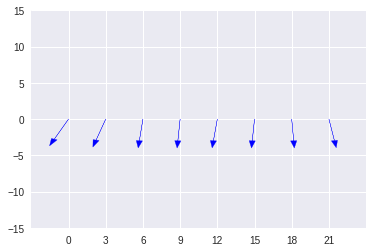

In [18]:
plot_wind_direction(chosenDf)